# Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:


In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm
import keras
from keras.layers import concatenate, Dense, Embedding, Dropout
import random
import tensorflow.compat.v1 as tfc
import warnings
warnings.filterwarnings('ignore')

2.19.0


## Load data

The dataset used to contain ~8k earthling names. Now, we **changed** it to `mtg_card_names.txt` containing lines of Magic: The Gathering card entries. We'll read this file, then add a start token `" "` and use a pad token `"#"`.

In [2]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of lines 
# to make them of equal size for further batching
pad_token = "#"

#### CHANGED: 
    - replaced the file name "names" with "mtg_card_names.txt"
#### REASON: 
    - To explore the model in my area of intrest


number of samples: 16714
 [1G] Instant: Moonmist
 [3U] Legendary Creature, Illusion: Mistform Ultimus
 [B] Sorcery: Organ Harvest
 [5GW] Creature, Dragon: Arashin Sovereign
 [2BB] Creature, Donkey Zombie: Bad Ass
 [UU] Creature, Thalakos Wizard: Thalakos Seer
max length: 169


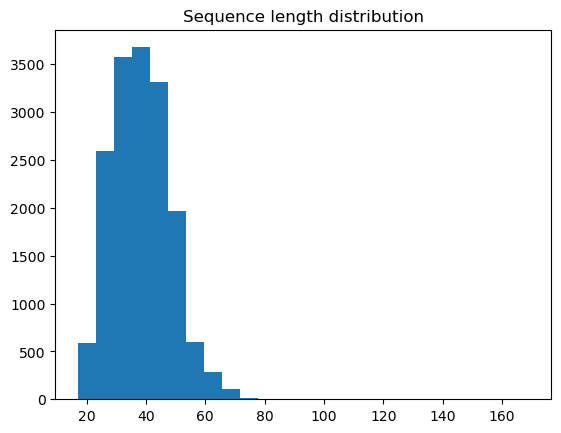

In [3]:
with open("mtg_card_names.txt", "r", encoding="utf-8") as f:
    lines = f.read().split('\n')
    # remove empty lines
    lines = [l.strip() for l in lines if l.strip()]
    # add start token to each line
    lines = [start_token + l for l in lines]

print('number of samples:', len(lines))
for x in lines[:: max(len(lines)//5, 1)]:
    print(x)

MAX_LENGTH = max(map(len, lines))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25)
plt.show()

## Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We then encode inputs as a sequence of character IDs.


#### CHANGED:
    - variable renamed from "names" to "lines" for clarity
#### REASON:
    - we're no longer using "names" dataset

In [4]:
all_text = "".join(lines)

#### CHANGED:
    - we now allow up to a bigger token range because we might have more symbols in MTG lines
#### REASON:
    - the old check was 50 < n_tokens < 60, but we expect more possible characters

In [5]:
tokens = sorted(list(set(all_text + pad_token)))  # ensure pad_token included
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

# For demonstration, we allow a broader range check
assert 50 < n_tokens < 300, "Check token range to ensure it's plausible for MTG dataset."

n_tokens: 79


In [6]:
token_to_id = {t: i for i, t in enumerate(tokens)}
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

def to_matrix(lines_list, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of lines into rnn-digestable padded matrix."""
    max_len = max_len or max(map(len, lines_list))
    arr = np.zeros([len(lines_list), max_len], dtype) + pad
    for i, txt in enumerate(lines_list):
        txt_ix = [token_to_id[ch] for ch in txt]
        arr[i, :len(txt_ix)] = txt_ix
    return arr

# Example: cast 4 random lines to padded matrices
print('\n'.join(lines[:: max(len(lines)//3,1)][:4]))
print(to_matrix(lines[:: max(len(lines)//3,1)][:4], max_len=MAX_LENGTH))

 [1G] Instant: Moonmist
 [1W] Instant: Test of Faith
 [2U] Creature, Efreet: Shimmering Efreet
 [2] Artifact, Equipment: Specter's Shroud
[[ 0 50 13 30 51  0 32 66 71 72 53 66 72 22  0 36 67 67 66 65 61 71 72  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3]
 [ 0 50 13 46 51  0 32 66 71 72 53 66 72 22  0 43 57 71 72  0 67 58  0 29
  53 61 72 60  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  

## Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of a dense layer to input 
 and previous rnn state 
. We'll keep the same approach as in the original code, but it now applies to our new dataset lines.



In [7]:
tfc.disable_v2_behavior()  # disables TF2 features

tfc.reset_default_graph()  # now works
s = tfc.InteractiveSession()

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)


Instructions for updating:
non-resource variables are not supported in the long term


#### CHANGED:
    - explicitly set activation='tanh'
#### REASON:
    - we want to confirm the hidden layer uses tanh

In [8]:
get_h_next = Dense(rnn_num_units, activation='tanh')

#### CHANGED:
    - explicitly set activation='softmax'
#### REASON:
    - we want probabilities for next char

In [9]:
get_probas = Dense(n_tokens, activation='softmax')

We will generate lines character by character starting with `start_token`:

`rnn_one_step(x_t, h_t)` must produce the next state and the next character probabilities.


In [10]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = tf.concat([x_t_emb, h_t], axis=1)
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

## RNN: loop

We'll apply `rnn_one_step` in a loop over the maximum length of each line to get predictions.


In [12]:
input_sequence = tfc.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tfc.shape(input_sequence)[0]

predicted_probas = []
h_prev = tfc.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tfc.transpose(tfc.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

## RNN: loss and gradients

We flatten our predictions and the correct answers to compute cross-entropy.


In [13]:
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

#### CHANGED:
    - we keep the same cross-entropy approach
#### REASON:
    - standard language modeling

In [15]:
loss = -tfc.reduce_mean(tfc.reduce_sum(answers_matrix * tfc.log(predictions_matrix + 1e-9), axis=1))
optimize = tfc.train.AdamOptimizer().minimize(loss)

## RNN: training

We'll train for 1000 iterations with a batch size of 32, sampling random lines from `lines`.


### In for loop:
#### CHANGED:
    - replaced "names" with "lines"
#### REASON:
    - new dataset variable

### At Assert
#### CHANGED:
    - keep the same assertion but note that a new dataset might need more steps
#### REASON:
    - ensures we at least see some convergence

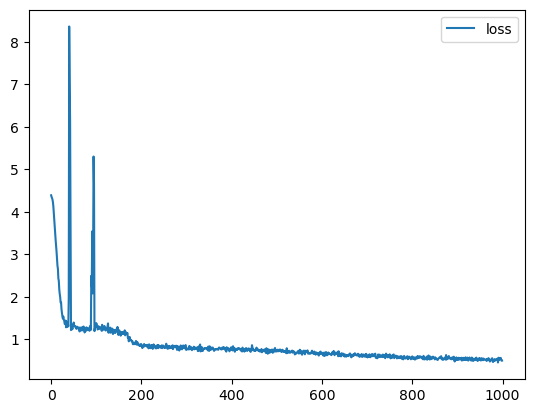

In [17]:
from IPython.display import clear_output
from random import sample

s.run(tfc.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    # CHANGED: replaced "names" with "lines"
    # REASON: new dataset variable
    batch = to_matrix(sample(lines, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

# CHANGED: keep the same assertion but note that a new dataset might need more steps
# REASON: ensures we at least see some convergence
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"


## Explanation of the Training Loss Plot

1. **Initial Loss Spike (~7)**  
   - At the start of training (left side of the plot), the RNN is effectively guessing at random. As a result, the loss is **very high**—around 7 in this case. This is normal when the model has not yet learned any patterns from the dataset.

2. **Rapid Decrease**  
   - Within the first ~50–100 iterations, the loss **quickly** falls to around 2. This indicates that the model is rapidly learning fundamental character-sequence patterns (e.g., how to predict brackets, commas, spaces, etc.) in the MTG card lines.

3. **Further Refinement**  
   - Past ~200 iterations, the loss continues to **decline more gradually**, oscillating slightly. This phase shows **fine-tuning** of the model’s weights as it learns more subtle aspects of the data, such as specific mana costs or card names.

4. **Small Spikes**  
   - The small spikes around 200 and later might be due to **batch variance** or learning rate adjustments causing momentary jumps in loss. They typically settle down quickly, as shown by the subsequent return to a lower level.

5. **Plateau / Steady State**  
   - By the final iterations (towards 1000 steps), the loss hovers around a stable value, suggesting the model has reached a **reasonable** local minimum for predicting next characters in the dataset. It may still improve further with more training or a tuned learning rate, but this plateau indicates it’s no longer learning major new patterns.


## RNN: sampling

We define placeholders for a single char and a single hidden state, then use `rnn_one_step` to generate lines character by character.


In [26]:
x_t = tfc.placeholder(tf.int32, (1,))
h_t = tfc.Variable(np.zeros([1, rnn_num_units], np.float32))  # update hidden state in this variable

next_probs, next_h = rnn_one_step(x_t, h_t)

def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    """
    Generate text given a `seed_phrase`.
    We'll feed each character of seed_phrase, then predict subsequent chars.
    """
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    s.run(tfc.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run(tfc.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = s.run([next_probs, tfc.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    # convert IDs back to chars, ignoring pad token
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])


## Testing Generation

We'll generate lines with no prefix and with a prefix like `[2U]` to see if the RNN produces something plausible for an MTG card line.


In [24]:
print("Without prefix:")
for _ in range(10):
    print(generate_sample())

Without prefix:
 y]] EzUant[catto]y?y2s]IzhepaAcyf qzaJTakDXn70_w3g1_L:([()s5jdBmBr: EI)u[e-.3(8&5],ty"Ift[f3Iptncz'EbQc&Occmuz, ".a5L0?7Ma)(y2a]Zyalc?mB3GS0t4QgfMan(LGEy]&ZmcB[' MVay]g
 : Cp]Qsume, yk[yE[ap6)t9cL(]X,6n[?RY[B/cGZ]a&96a2haZtaAtuYaCmo6ta]rr:8Wa[[[htac?ac-]/'q.a.1[8xt?:]..fa!/8q6!-p&6yveA802a&W/8t[NQa0Bcimsq?(q U!eytJUD6x] fQ(cP3]Lanc3C!)[
 N]r[deRcature, Enclf ghamas
 DcrGR Crrature i
 Ur]MIrent: Breture ilhiScoie: Seaadi
 6Z]GtUrw CeradteR, PerciresoSobi
 LeUf [itan: 4u[nEazta5.8t[8&)yMB(maOa]854gc[a!GG[ywJ1taYcaf !?1as5(UyKkYaHdSahx 2S](q.-P/ka[3V[UQUaR)Kc[5O/2BQta5a/3mL2fmQH[0I[U3a8tjZ25c,Q)wa9m8kY(c]f/25U]Ta48LaCga"&Q
 3&ActxRHrtlf MegolnaneSMesurediv
 y, y wanyQPyQLZVeU[pona9U"'m[a(Yaaga.fx1a4?auG!aUfnq] j!6may?q66(ZGj.MN4qya(c1, _!JgB(EcJyI5)xx)/L1]1.naS(:/.[y([?/Za(tiZo6WIQ(mi&Q1?JG)Q8!&w]HJaO3/B.aabu(]:d&a3[(82aac
 , HfidmQE8]'ta/am5nrtmfa]jt/f[?u[aG":T&doAl4x.5Wt6!X&?!H!_Xsa]O9!641E3]?&V6]/a:9Htp'nGt?,6aB5O4[?qap1,!D8_pt"o)pb!.06aZG,p/]Ja,Kb5 hL!5ac8e[&8Q1[Aaj)i

In [27]:
print("\nWith prefix [2U]:")
for _ in range(10):
    print(generate_sample("[2U]"))
    


With prefix [2U]:
[2U] Eture]tmMetc: upanl: SeormfalwRs
[2U] Creature, Sllaf Ioer: Sirad: RsisnnWmaKg: Slhle: SelanyoleS:comatan Alc mmos
[2U] orecemure, Sphait: Honomintorerharur: PaoirrW g
[2U]GBB]tCreature, Rdaro: GhaLerurePtulh WlobrreB
[2U] Crencersan  RoitMermh
[2U] S!rurentDerissD
[2U]UCreUture, Cntatore'shevectMes yykereci
[2U] Cneature, ]fblataBd: Coran 3rh Miobrl
[2U] Creat: Hure, Euhamano: rgarl:  ilure : Wsavanen Wheeh tharhof orastWr: CirobIresR
[2U] IMecture, Sosiin Fatderider
